## Preprocessing


In [27]:
import os
import yaml

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import seaborn as sns
import folium
from folium.plugins import HeatMap

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statistics import mean

from math import sqrt
from copy import deepcopy
from datetime import datetime
import requests
import re

import keras
from keras.models import Sequential , load_model
from keras.layers import Dense , LSTM, Dropout , Conv1D , MaxPooling1D , Reshape , Activation
from keras.layers import Masking , TimeDistributed, Bidirectional
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import History , ModelCheckpoint


In [28]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import pandas as pd

import seaborn as sns
sns.set()


from statsmodels.tsa.stattools import adfuller


from statsmodels.tsa.stattools import acf, pacf
from copy import deepcopy


from datetime import datetime

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [29]:
# Functions :

"""Plots a simple serie in PLOTLY."""
def jsplot(dates , values , mode = 'lines+markers'):

    data = [go.Scatter(
              x=dates,
              y=values,
              mode = mode)]

    iplot(data)


"""Plot multiple series in PLOTLY:"""
def jsplot_multiple(dates , values , mode = 'lines+markers'):

    data = []
    for col in values.columns:
        splot = go.Scatter(
                        x=dates,
                        y=values[col],
                        mode = mode,
                        name = str(col) )
        data.append(splot)

    iplot(data)


"""Function that test the stationarity of a Time series by
computing and plotting rolling statistics, and then by performing
An augmented Dickey Fuller test."""

def test_stationarity(timeseries , window = 50):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries,label='Original')
    mean = plt.plot(rolmean, color='red' , label='Rolling Mean')
    std = plt.plot(rolstd, label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    try:
        dftest = adfuller(timeseries.dropna(), autolag='AIC')
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        print(dfoutput)
    except:
        print('test failed')



"""Performs Acp - Pacp Analysis on a time serie."""
def acp_pacp(timeseries , nlags = 30):
    lag_acf = acf(timeseries, nlags=nlags)
    lag_pacf = pacf(timeseries, nlags=nlags, method='ols')

    print('lag_acf')
    fig = plt.figure(figsize=(7 , 6))

    sns.barplot( np.arange(len(lag_acf)) , lag_acf , palette = 'GnBu_d')


    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')

    plt.show()
    print('lag_pacf')
    fig = plt.figure(figsize=(7, 6))

    sns.barplot( np.arange(len(lag_pacf)) , lag_pacf , palette = 'GnBu_d')

    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')

    plt.show()

In [30]:
# caracs = pd.read_csv('../input/caracteristics.csv' , encoding = 'latin-1') # Caracteristics of the accidents.
# places = pd.read_csv('../input/places.csv' ) # Places features.
# users = pd.read_csv('../input/users.csv' ) # Users involved in the accdient features.
# vehicles = pd.read_csv('../input/vehicles.csv') # Vehicles features.

In [31]:
df = pd.read_csv('../input/velo_df_paris_final.csv') # Accidents features.
caracs = df[["Num_Acc", "an", "mois", "jour", "hrmn", "lum", "agg", "int", "atm", "col", "com", "adr", "lat", "long", "dep"]]
users = df[['Num_Acc', 'grav', 'sexe', 'trajet', 'secu', 'locp', 'an_nais']]


In [32]:
caracs.an.value_counts()

16    858
14    803
17    770
13    765
15    748
7     746
11    722
18    717
12    703
9     697
8     689
10    602
6     541
5     472
Name: an, dtype: int64

In [33]:
holidays = pd.read_csv('../input/holidays.csv') # Vehicles features.

In [34]:
dtsers = caracs.loc[(caracs.dep.isin([750])) , ['Num_Acc' , 'jour' , 'mois' , 'an']]

dtsers['day'] = pd.to_datetime((2000+dtsers.an)*10000+dtsers.mois*100+dtsers.jour,format='%Y%m%d')
dtsers.drop(['jour' , 'mois' , 'an'] , axis = 1 ,inplace = True)


dtsers = dtsers.groupby('day' , as_index = False).count()

# Dummy Variable Holiday
dtsers['isholiday'] = 0
dtsers.loc[dtsers.day.isin(holidays.date) , 'isholiday'] = 1

# Week day and month
dtsers['weekday'] = dtsers.day.dt.weekday
dtsers['month'] = dtsers.day.dt.month
# Dummification
dtsers = pd.get_dummies(dtsers , columns = ['weekday' , 'month'])

print(' the 3 last years of the time series:')
jsplot(dtsers.day , dtsers.Num_Acc )

 the 3 last years of the time series:


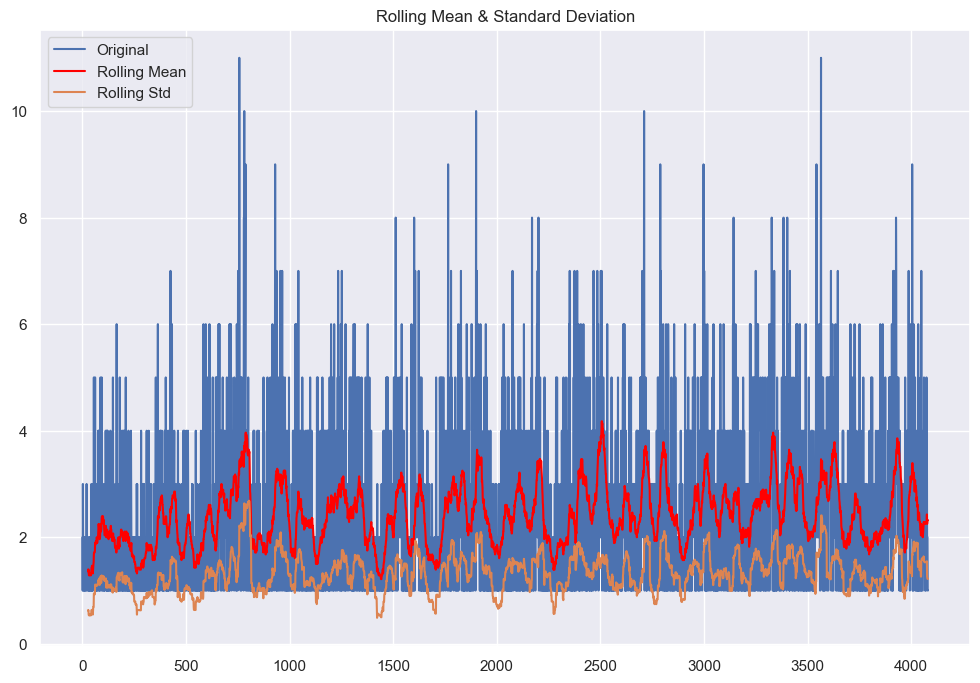

Results of Dickey-Fuller Test:
Test Statistic                -1.104864e+01
p-value                        5.146543e-20
#Lags Used                     1.200000e+01
Number of Observations Used    4.069000e+03
Critical Value (1%)           -3.431958e+00
Critical Value (5%)           -2.862251e+00
Critical Value (10%)          -2.567148e+00
dtype: float64


In [35]:
# Some statistics :
test_stationarity(dtsers.Num_Acc , window = 28)


lag_acf


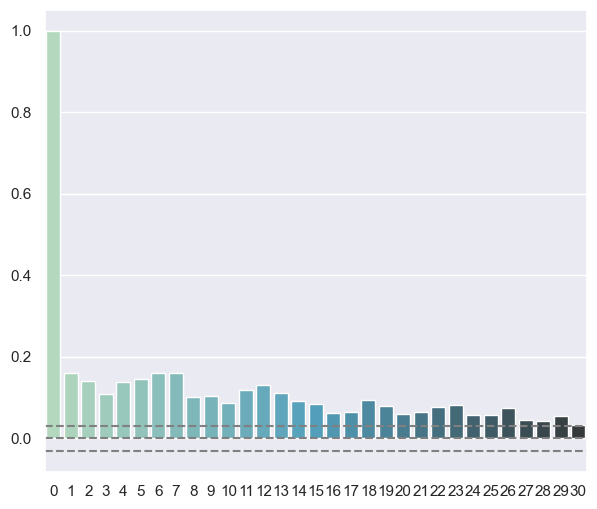

lag_pacf


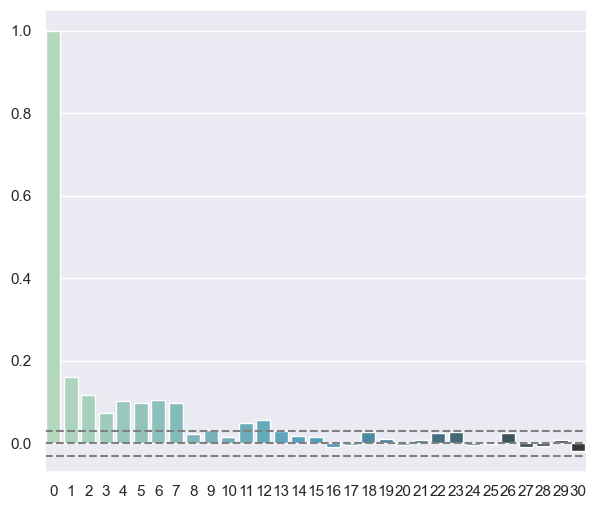

In [36]:
acp_pacp(dtsers.Num_Acc)

In [37]:
tempas = caracs.loc[caracs.dep == 750 , ['Num_Acc' , 'hrmn']]
tempas['hour'] = tempas['hrmn'].apply(lambda x:str(x).zfill(4)[:2])


grave_accs = users[users.grav.isin([2,3]) ].Num_Acc

tempas['gravity'] = 0
tempas.loc[tempas.Num_Acc.isin(grave_accs),'gravity'] = 1


occs = tempas.drop('hrmn' , axis = 1).groupby('hour' , as_index = False).agg({'Num_Acc' : 'count' , 'gravity' : 'sum'})



trace1 = go.Scatter(
    x=list(occs.hour),
    y=list(occs.Num_Acc),
    name='Total Number of accidents',
    mode='none',
    fill='tozeroy',
    marker=dict(
        color='rgb(106,81,163)'
    )
)

trace2 = go.Scatter(
    x=list(occs.hour),
    y=list(occs.gravity),
    name='Grave accidents',
    mode='none',
    fill='tozeroy',
    marker=dict(
        color='rgb(158,154,200)'
    )
)

data = [trace1 , trace2]

layout = go.Layout(
    title='Repartition of accidents per Hour',
    autosize=False,
    width=1000,
    height=500
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [38]:
tempas = caracs.loc[caracs.dep == 750 ,['Num_Acc']]
tempas['date'] = pd.to_datetime((2000+caracs.an)*10000+caracs.mois*100+caracs.jour,format='%Y%m%d')
tempas['weekday'] = tempas['date'].dt.weekday.apply(lambda x:str(x).zfill(2))

tempas['gravity'] = 0
tempas.loc[tempas.Num_Acc.isin(grave_accs),'gravity'] = 1


occs = tempas.drop('date' , axis = 1).groupby('weekday' , as_index = False).agg({'Num_Acc' : 'count' , 'gravity' : 'sum'})



trace1 = go.Scatter(
    x=list(occs.weekday),
    y=list(occs.Num_Acc),
    name='Total Number of accidents',
    mode='none',
    fill='tozeroy',
    marker=dict(
        color='rgb(106,81,163)'
    )
)

trace2 = go.Scatter(
    x=list(occs.weekday),
    y=list(occs.gravity),
    name='Grave accidents',
    mode='none',
    fill='tozeroy',
    marker=dict(
        color='rgb(158,154,200)'
    )
)

data = [trace1 , trace2]

layout = go.Layout(
    title='Repartition of accidents per Hour',
    autosize=False,
    width=1000,
    height=500
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [39]:
tempas = caracs.loc[caracs.dep == 750 ,['Num_Acc' , 'mois']]
tempas['mois'] = tempas['mois'].apply(lambda x:str(x).zfill(2))

tempas['gravity'] = 0
tempas.loc[tempas.Num_Acc.isin(grave_accs),'gravity'] = 1


occs = tempas.groupby('mois' , as_index = False).agg({'Num_Acc' : 'count' , 'gravity' : 'sum'})



trace1 = go.Scatter(
    x=list(occs.mois),
    y=list(occs.Num_Acc),
    name='Total Number of accidents',
    mode='none',
    fill='tozeroy',
    marker=dict(
        color='rgb(106,81,163)'
    )
)

trace2 = go.Scatter(
    x=list(occs.mois),
    y=list(occs.gravity),
    name='Grave accidents',
    mode='none',
    fill='tozeroy',
    marker=dict(
        color='rgb(158,154,200)'
    )
)

data = [trace1 , trace2]

layout = go.Layout(
    title='Repartition of accidents per Hour',
    autosize = False,
    width = 1000,
    height = 500
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [40]:
def evaluate(y_true , y_pred , dates):

    try:
        true_value , prediction = y_true.sum(axis = 1), y_pred.sum(axis=1).round()
    except:
        true_value , prediction = y_true, y_pred.round()

    print('Mean Absolute Error   :' , round(abs(true_value - prediction).mean() , 2))
    print('Root Mean Square Error:' , round(sqrt(((true_value - prediction)**2).mean()) , 2) )
    print('Mean Percentage Error :' , round((abs(true_value - prediction)/true_value).mean() , 2)  )

    error = pd.Series(true_value - prediction)

    #density plot :
    print('Error Density :')
    error.plot.density()
    plt.show()

    # mean of error and correlation :
    print('Mean Error                       :' , round(mean(error) , 2 ))
    print('True Value And error Correlation :' , round(np.corrcoef(error , true_value)[0 , 1] , 2))

    # plot :

    to_plot = pd.DataFrame({'target' : y_true.reshape(-1) , 'prediction' : y_pred.reshape(-1)})

    jsplot_multiple(dates , to_plot)

Mean Absolute Error   : 1.51
Root Mean Square Error: 1.99
Mean Percentage Error : 0.72
Error Density :


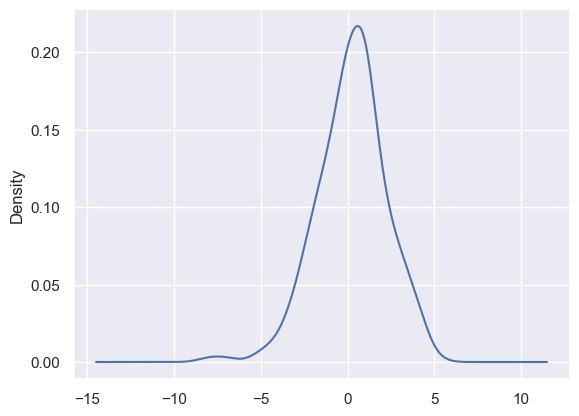

Mean Error                       : 0.23
True Value And error Correlation : 0.68


In [41]:
# Naive Model :

new , old = (dtsers.loc[dtsers.day.dt.year == 2016 , ['day' , 'Num_Acc']].reset_index(drop = True) ,
             dtsers.loc[dtsers.day.dt.year == 2015 , ['day' , 'Num_Acc']].reset_index(drop = True)[:365])

old.columns = ['day' , 'old']

new['weekofyear'] , new['dayofweek'] = new.day.dt.weekofyear , new.day.dt.dayofweek
old['weekofyear'] , old['dayofweek'] = old.day.dt.weekofyear , old.day.dt.dayofweek

merged = new.merge(old , on = ['weekofyear' , 'dayofweek'])


evaluate(merged.Num_Acc.values , merged.old.values , dtsers.day[-365:])

In [42]:
from prophet import Prophet


In [43]:
holidays = holidays.rename(columns={'date': 'ds', 'nom_jour_ferie': 'holiday'})

In [44]:
#Initialisation of the model.
model = Prophet(holidays = holidays , yearly_seasonality=True , weekly_seasonality=True, daily_seasonality=False)

#train & test set.
histo , new = dtsers[dtsers.day.dt.year].reset_index(drop = True) , dtsers[dtsers.day.dt.year
                                                                                  == 2016].reset_index(drop = True)

# We rename the columns before fitting the model to Prophet.
ncols = histo.columns.values
ncols[0] , ncols[1] = 'ds' , 'y'

histo.columns , new.columns = ncols , ncols

# We fit the model.
model.fit(histo)


# Prediction
ypred = model.predict(new)['yhat'].round()

# Evaluation
evaluate(new.y.values , ypred.values , dtsers.day[-365:])

KeyError: "None of [Int64Index([2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005,\n            ...\n            2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018],\n           dtype='int64', length=4082)] are in the [columns]"

In [ ]:
import keras
from keras.models import Sequential , load_model
from keras.layers import Dense , LSTM, Dropout , Conv1D , MaxPooling1D , Reshape , Activation
from keras.layers import Masking , TimeDistributed, Bidirectional
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import History , ModelCheckpoint

In [45]:
def reshape_timeseries(series , target_ids, window_size , take_curr = True , scale = True):


    # Converting the dataset to a suitable format :
    X = series.values
    Y = series.iloc[ : , target_ids].values

    # Scaling the data
    if scale:
        maxes = Y.max(axis = 0)
        Y = np.divide( Y , maxes)
        X = MinMaxScaler().fit_transform(X)

    # Conversion to time series with keras object
    ts = TimeseriesGenerator(X , Y , length = window_size , batch_size = X.shape[0])
    X , Y = ts[0]

    # Masking
    if take_curr:
        for timestep in X[: , window_size - 1]:
            timestep[target_ids] = [-2 for i in target_ids]
    else:
        X = X[: , :-1]

    if scale:
        return X , Y , maxes

    return X,Y

In [46]:
X

NameError: name 'X' is not defined

In [47]:
def model(X , Y , lr = 0.001,
          lstm_layers = [] , lstm_dropout = [],
          dense_layers = [] , dense_dropout = [] ,
          ntest_day = 365 , epochs = 10 , batch_size = 32):


    # training and testing set :
    length , timesteps , features = X.shape[0] , X.shape[1] , X.shape[2]
    target_shape = Y.shape[1]

    # Validation rate to pass to the Sequential Model :
    val_rate = ntest_day/length


    ############################################ Model :

    checkpoint = ModelCheckpoint('model' , save_best_only=True)

    model = Sequential()

    # Masking Layer.
    model.add(Masking(mask_value = -2 , input_shape=(X.shape[1],  X.shape[2])    ))


    # BI-LSTM Layers.
    for i in range(len(lstm_layers)):
        rsequs  = not (i == (len(lstm_layers) - 1))
        model.add(Bidirectional( LSTM(lstm_layers[i] , return_sequences = rsequs) ,input_shape=(X.shape[1], X.shape[2]) ) )
        model.add(Dropout(lstm_dropout[i]))


    # Dense Layers.
    for i in range(len(dense_layers)):
        model.add(Dense(dense_layers[i]) )
        model.add(Dropout(dense_dropout[i]))
        model.add(Activation('relu'))


    model.add(Dense(target_shape))
    Nadam = keras.optimizers.Nadam(lr = lr , beta_1=0.9, beta_2=0.999, epsilon=1e-08)#, schedule_decay=0.0004)
    model.compile(loss='mean_squared_error', optimizer='adam')

    print('Model Summary:')
    print(model.summary())

    # fitting the data
    print('\n\n Training :')
    model.fit(X, Y, epochs= epochs, batch_size=batch_size, validation_split = val_rate, callbacks = [checkpoint])


    # loading best_model
    model = load_model('model')

    return model

Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 28, 21)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 40)               6720      
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense (Dense)               (None, 500)               20500     
                                                                 
 dropout_1 (Dropout)         (None, 500)               0         
                                                                 
 activation (Activation)     (None, 500)               0         
                                         

2023-12-18 19:28:57.088105: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


57/58 [============================>.] - ETA: 0s - loss: 0.0230

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


58/58 [==============================] - 25s 373ms/step - loss: 0.0228 - val_loss: 0.0167
Epoch 2/20
57/58 [============================>.] - ETA: 0s - loss: 0.0187

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


58/58 [==============================] - 26s 457ms/step - loss: 0.0187 - val_loss: 0.0165
Epoch 3/20
58/58 [==============================] - 0s 7ms/step - loss: 0.0177 - val_loss: 0.0167
Epoch 4/20
54/58 [==========================>...] - ETA: 0s - loss: 0.0172

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


58/58 [==============================] - 100s 2s/step - loss: 0.0172 - val_loss: 0.0162
Epoch 5/20
56/58 [===========================>..] - ETA: 0s - loss: 0.0169

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


58/58 [==============================] - 34s 597ms/step - loss: 0.0170 - val_loss: 0.0160
Epoch 6/20
58/58 [==============================] - 0s 7ms/step - loss: 0.0167 - val_loss: 0.0166
Epoch 7/20
58/58 [==============================] - 0s 7ms/step - loss: 0.0163 - val_loss: 0.0161
Epoch 8/20
58/58 [==============================] - 0s 7ms/step - loss: 0.0165 - val_loss: 0.0170
Epoch 9/20
58/58 [==============================] - 0s 7ms/step - loss: 0.0164 - val_loss: 0.0161
Epoch 10/20
58/58 [==============================] - 0s 7ms/step - loss: 0.0161 - val_loss: 0.0161
Epoch 11/20
58/58 [==============================] - 0s 7ms/step - loss: 0.0161 - val_loss: 0.0162
Epoch 12/20
58/58 [==============================] - 0s 7ms/step - loss: 0.0161 - val_loss: 0.0163
Epoch 13/20
57/58 [============================>.] - ETA: 0s - loss: 0.0160

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


58/58 [==============================] - 17s 298ms/step - loss: 0.0160 - val_loss: 0.0158
Epoch 14/20
58/58 [==============================] - 0s 7ms/step - loss: 0.0160 - val_loss: 0.0162
Epoch 15/20
58/58 [==============================] - 0s 7ms/step - loss: 0.0157 - val_loss: 0.0159
Epoch 16/20
58/58 [==============================] - 0s 7ms/step - loss: 0.0156 - val_loss: 0.0161
Epoch 17/20
58/58 [==============================] - 0s 7ms/step - loss: 0.0157 - val_loss: 0.0162
Epoch 18/20
58/58 [==============================] - 0s 7ms/step - loss: 0.0157 - val_loss: 0.0158
Epoch 19/20
58/58 [==============================] - 0s 7ms/step - loss: 0.0158 - val_loss: 0.0165
Epoch 20/20
58/58 [==============================] - 0s 7ms/step - loss: 0.0156 - val_loss: 0.0162


2023-12-18 19:45:50.584511: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-12-18 19:45:51.716863: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-12-18 19:45:52.029308: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-12-18 19:45:52.045665: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-12-18 19:45:52.583558: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 5 outputs but the _output_sh

12/12 [==============================] - 1s 2ms/step
Mean Absolute Error   : 1.01
Root Mean Square Error: 1.39
Mean Percentage Error : 0.55
Error Density :


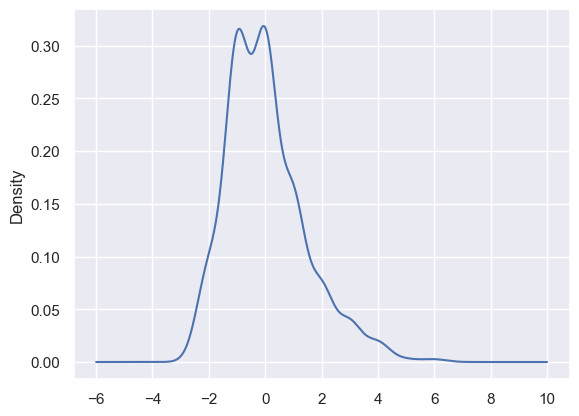

Mean Error                       : 0.03
True Value And error Correlation : 0.92


In [48]:
X , Y , maxes  = reshape_timeseries(dtsers.iloc[:, 1:] , [0], window_size = 28 , take_curr = True , scale = True)
ntest_day = 365

nmodel = model(X , Y , lr = 0.002, lstm_layers = [20 ] , lstm_dropout = [.3 ] ,
               dense_layers = [500] , dense_dropout = [.5] , batch_size = 64 , epochs = 20)

# Computing Validation scores : MAE - RMSE - MPE
y_predict = nmodel.predict(X[- ntest_day:]) * maxes
y_true = Y[- ntest_day:] * maxes

evaluate(y_true , y_predict , dtsers.day[-365:])

In [ ]:
def long_term_prediction(model, X, nb_target):
    predictions = []
    new_line = X[0].reshape(1, *X.shape[1:])
    pred = model.predict(new_line)
    predictions.append(pred)

    for line in X[1:]:
        old_line = deepcopy(line)
        old_line[-2, :nb_target] = pred.flatten()[:nb_target]  # Utiliser seulement les premiers nb_target éléments

        pred = model.predict(old_line.reshape(1, *X.shape[1:]))
        predictions.append(pred)

    return np.array(predictions).reshape(-1, nb_target)


In [50]:
X.shape

(4054, 28, 21)

In [ ]:
# Computing Validation scores : MAE - RMSE - MPE
y_predict = long_term_prediction(nmodel , X[- ntest_day:] , 1)* maxes
y_true = Y[- ntest_day:] * maxes

print('Shapes before evaluation:')
print('y_true shape:', y_true.shape)
print('y_predict shape:', y_predict.shape)

# Calcul des métriques d'évaluation
evaluate(y_true, y_predict, dtsers.day[-365:])


1/1 [==============================] - 0s 17ms/step
Shapes before evaluation:
y_true shape: (365, 19)
y_predict shape: (6935, 19)


ValueError: operands could not be broadcast together with shapes (365,) (6935,) 

In [51]:
cdtsers = caracs.loc[(caracs.dep.isin([750])) , ['Num_Acc' , 'dep', 'com', 'jour' , 'mois' , 'an']]


cdtsers['day'] = pd.to_datetime((2000+cdtsers.an)*10000+cdtsers.mois*100+cdtsers.jour,format='%Y%m%d')
cdtsers.drop(['jour' , 'mois' , 'an'] , axis = 1 ,inplace = True)

def correct(x):
    if x>100:
        return x - 100
    return x

cdtsers.com = cdtsers.com.apply( correct )

cdtsers = cdtsers.groupby(['day' , 'dep' , 'com'] , as_index = False).count()

cdtsers = cdtsers.pivot_table(index = ['day' , 'dep'] , columns = 'com' , values = 'Num_Acc').reset_index()

cdtsers.fillna(0).head()

cdtsers['isholiday'] = 0
cdtsers.loc[cdtsers.day.isin(holidays.ds) , 'isholiday'] = 1



cdtsers['weekday'] = cdtsers.day.dt.weekday
cdtsers['month'] = cdtsers.day.dt.month
cdtsers = pd.get_dummies(cdtsers , columns = ['weekday' , 'month'])


cdtsers.drop([14 , 'dep'] , axis = 1 , inplace = True)
cdtsers.fillna(0 , inplace = True)

In [ ]:
print(cdtsers.info)

<bound method DataFrame.info of             day    1    2    3    4    5    6    7    8    9  ...  month_3  \
0    2005-01-03  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...        0   
1    2005-01-04  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...        0   
2    2005-01-05  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...        0   
3    2005-01-06  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...        0   
4    2005-01-08  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...        0   
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...      ...   
4077 2018-12-21  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...        0   
4078 2018-12-22  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...        0   
4079 2018-12-24  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...        0   
4080 2018-12-26  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...        0   
4081 2018-12-30  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...        0   

      month_4  month_5  month_6

In [52]:
X , Y , maxes  = reshape_timeseries(cdtsers.iloc[: , 1:] , list(range(19)), window_size = 28 , take_curr = True , scale = True)

ntest_day = 365

nmodel = model(X , Y , lr = 0.005, lstm_layers = [64 , 64] , lstm_dropout = [.2 , .2] ,
               dense_layers = [64] , dense_dropout = [.2] , batch_size = 64 , epochs = 20)

Model Summary:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_1 (Masking)         (None, 28, 39)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 28, 128)          53248     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 28, 128)           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


58/58 [==============================] - 47s 694ms/step - loss: 0.0176 - val_loss: 0.0166
Epoch 2/20
58/58 [==============================] - ETA: 0s - loss: 0.0166

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


58/58 [==============================] - 43s 748ms/step - loss: 0.0166 - val_loss: 0.0164
Epoch 3/20
58/58 [==============================] - ETA: 0s - loss: 0.0165

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


58/58 [==============================] - 37s 650ms/step - loss: 0.0165 - val_loss: 0.0164
Epoch 4/20
58/58 [==============================] - ETA: 0s - loss: 0.0165

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


58/58 [==============================] - 36s 623ms/step - loss: 0.0165 - val_loss: 0.0164
Epoch 5/20
58/58 [==============================] - 2s 38ms/step - loss: 0.0164 - val_loss: 0.0164
Epoch 6/20
58/58 [==============================] - ETA: 0s - loss: 0.0164

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


58/58 [==============================] - 37s 643ms/step - loss: 0.0164 - val_loss: 0.0163
Epoch 7/20
58/58 [==============================] - 2s 37ms/step - loss: 0.0165 - val_loss: 0.0163
Epoch 8/20
58/58 [==============================] - 2s 38ms/step - loss: 0.0164 - val_loss: 0.0164
Epoch 9/20
58/58 [==============================] - ETA: 0s - loss: 0.0164

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


58/58 [==============================] - 37s 651ms/step - loss: 0.0164 - val_loss: 0.0163
Epoch 10/20
58/58 [==============================] - 2s 34ms/step - loss: 0.0164 - val_loss: 0.0164
Epoch 11/20
57/58 [============================>.] - ETA: 0s - loss: 0.0164

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


58/58 [==============================] - 37s 642ms/step - loss: 0.0164 - val_loss: 0.0163
Epoch 12/20
58/58 [==============================] - 2s 36ms/step - loss: 0.0164 - val_loss: 0.0163
Epoch 13/20
58/58 [==============================] - 2s 36ms/step - loss: 0.0164 - val_loss: 0.0163
Epoch 14/20
58/58 [==============================] - 2s 37ms/step - loss: 0.0164 - val_loss: 0.0163
Epoch 15/20
58/58 [==============================] - 2s 40ms/step - loss: 0.0164 - val_loss: 0.0164
Epoch 16/20
58/58 [==============================] - 2s 38ms/step - loss: 0.0164 - val_loss: 0.0163
Epoch 17/20
58/58 [==============================] - 2s 36ms/step - loss: 0.0164 - val_loss: 0.0163
Epoch 18/20
58/58 [==============================] - 2s 36ms/step - loss: 0.0164 - val_loss: 0.0163
Epoch 19/20
58/58 [==============================] - 2s 37ms/step - loss: 0.0164 - val_loss: 0.0163
Epoch 20/20
57/58 [============================>.] - ETA: 0s - loss: 0.0164

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


58/58 [==============================] - 36s 635ms/step - loss: 0.0163 - val_loss: 0.0163


2023-12-18 19:59:33.965560: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2023-12-18 19:59:34.248265: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2023-12-18 19:59:34.742653: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2023-12-18 19:59:34.924423: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-12-18 19:59:34.940897: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 5 outputs but the _ou

In [53]:
cdtsers.day.info

<bound method Series.info of 0      2005-01-03
1      2005-01-04
2      2005-01-05
3      2005-01-06
4      2005-01-08
          ...    
4077   2018-12-21
4078   2018-12-22
4079   2018-12-24
4080   2018-12-26
4081   2018-12-30
Name: day, Length: 4082, dtype: datetime64[ns]>

12/12 [==============================] - 4s 11ms/step
Mean Absolute Error   : 0.99
Root Mean Square Error: 1.35
Mean Percentage Error : inf
Error Density :


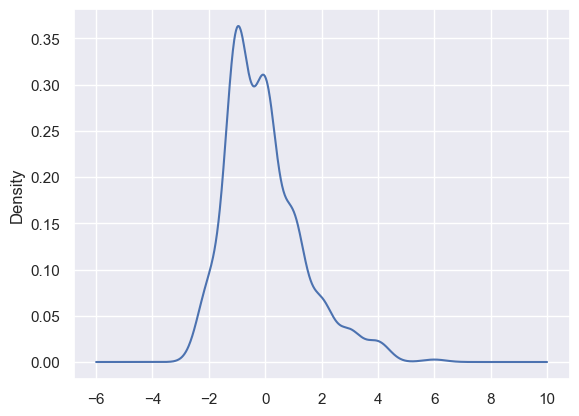

Mean Error                       : -0.04
True Value And error Correlation : 0.94


In [ ]:
# Evaluating:
y_predict = (nmodel.predict(X[- ntest_day:]) * maxes).sum(axis = 1)
y_true = (Y[- ntest_day:] * maxes).sum(axis = 1)

evaluate(y_true , y_predict , cdtsers.day[-365:])

In [ ]:
print(caracs)

           Num_Acc  an  mois  jour  hrmn  lum  agg  int  atm  col  com  \
0     201800050213  18     1    20  1300    1    2    2    2    6  101   
1     201800050217  18     1    30  1835    5    2    2    1    3  101   
2     201800050225  18     2    19  1620    1    2    3    8    6  101   
3     201800050240  18     4     6  1540    1    2    2    1    3  101   
4     201800050241  18     4    12  1205    1    2    1    1    6  101   
...            ...  ..   ...   ...   ...  ...  ...  ...  ...  ...  ...   
9828  201500056062  15    12     7  1809    5    2    7    1    3  108   
9829  201500056076  15    12    18  1600    1    2    3    1    3  115   
9830  201500056078  15    12    18  2159    5    2    2    1    3  105   
9831  201500056079  15    12    20  1930    5    2    7    1    3  109   
9832  201500056190  15     3    25  1530    1    2    4    1    3  118   

                           adr           lat           long  dep  
0     12, QUAI FRANCOIS MITTER  4.886010e+06

In [54]:
import pandas as pd
import numpy as np

# Paramètres
num_acc_values = range(1, 366)  # Num_Acc sera de 1 à 365
dep_value = 750  # Valeur fixe pour 'dep'
com_values = np.random.randint(1000, 9999, size=len(num_acc_values))  # Nombres aléatoires pour 'com'
jour_values = np.repeat(range(1, 32), len(com_values)//31 + 1)[:len(com_values)]  # Jours de 1 à 31
mois_values = np.tile(range(1, 13), len(com_values)//12 + 1)[:len(com_values)]  # Mois de 1 à 12
an_value = 2019  # Année fixe pour 'an'

# Création de la DataFrame
data = {
    'Num_Acc': num_acc_values,
    'dep': dep_value,
    'com': com_values,
}

df = pd.DataFrame(data)

# Afficher la DataFrame
print(df)


# Créer une séquence de dates pour tous les jours de l'année 2019
start_date = '2019-01-01'
end_date = '2019-12-31'

date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Créer une DataFrame avec la colonne 'date'
df['date'] = pd.DataFrame({'date': date_range})

# Ajouter des colonnes pour le jour, le mois et l'année
df['jour'] = df['date'].dt.day
df['mois'] = df['date'].dt.month
df['an'] = df['date'].dt.year

# Supprimer la colonne 'date'
df.drop('date', axis=1, inplace=True)

# Afficher la DataFrame
print(df.columns)


     Num_Acc  dep   com
0          1  750  3434
1          2  750  1409
2          3  750  7552
3          4  750  7827
4          5  750  4006
..       ...  ...   ...
360      361  750  5966
361      362  750  1838
362      363  750  5990
363      364  750  4764
364      365  750  8827

[365 rows x 3 columns]
Index(['Num_Acc', 'dep', 'com', 'jour', 'mois', 'an'], dtype='object')


In [55]:


pred = df.loc[df.dep.isin([750]), ['Num_Acc', 'dep', 'com', 'jour', 'mois', 'an']]

pred['day'] = pd.to_datetime(pred['an'].astype(str) + pred['mois'].apply(lambda x: f'{x:02}') + pred['jour'].apply(lambda x: f'{x:02}'), format='%Y%m%d')
pred.drop(['jour', 'mois', 'an'], axis=1, inplace=True)

def correct(x):
    if x > 100:
        return x - 100
    return x

pred['com'] = pred['com'].apply(correct)

pred = pred.groupby(['day', 'dep', 'com'], as_index=False).count()

pred = pred.pivot_table(index=['day', 'dep'], columns='com', values='Num_Acc').reset_index()

pred.fillna(0, inplace=True)

pred['isholiday'] = 0
pred.loc[pred['day'].isin(holidays.ds), 'isholiday'] = 1

pred['weekday'] = pred['day'].dt.weekday
pred['month'] = pred['day'].dt.month
pred = pd.get_dummies(pred, columns=['weekday', 'month'])

# pred.drop([2, 'dep'], axis=1, inplace=True)
pred.drop(['dep'], axis=1, inplace=True)
pred.fillna(0, inplace=True)


In [60]:
X_new , Y_new, maxes  = reshape_timeseries(pred.iloc[:, 1:] , [0], window_size = 28 , take_curr = True , scale = True)
ntest_day = 365



# Computing Validation scores : MAE - RMSE - MPE
y_predict = nmodel.predict(X_new) * maxes
y_true = Y_new[- ntest_day:] * maxes


evaluate(y_true , y_predict , cdtsers.day[-365:])

ValueError: cannot reshape array of size 3604552 into shape (39)